***
# Name: Pratik Sayanekar | Student ID: 20200161
## COMP47650 Deep Learning Project
## Dataset -  B1: Twitter Sentiment Classification
***

<b>This notebook illustrates several modeling strategies for deep neural networks related to tweets.</b>

<div class="list-group" id="list-tab" role="tablist">
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Table of Contents</h3>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#dataset" role="tab" aria-controls="profile">Reading Preprocessed Data<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#Tokenization" role="tab" aria-controls="messages">Tokenization and Padding of each tweet<span class="badge badge-primary badge-pill">2</span></a>   
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#Word2Vec" role="tab" aria-controls="settings">Word2Vec Embedding<span class="badge badge-primary badge-pill">3.1</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#glove" role="tab" aria-controls="settings">Glove : Pretrained word embedding<span class="badge badge-primary badge-pill">3.2</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#Models" role="tab" aria-controls="settings">Deep Learning Models<span class="badge badge-primary badge-pill">4</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#cnn" role="tab" aria-controls="settings">CNN<span class="badge badge-primary badge-pill">4.1</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#cnn2" role="tab" aria-controls="settings">CNN_v2<span class="badge badge-primary badge-pill">4.2</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#lstm" role="tab" aria-controls="settings">LSTM<span class="badge badge-primary badge-pill">4.3</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#lstm2" role="tab" aria-controls="settings">LSTM_v2<span class="badge badge-primary badge-pill">4.4</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#bilstm" role="tab" aria-controls="settings">Proposed Model: BiLSTM + CNN <span class="badge badge-primary badge-pill">5</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#conclusion" role="tab" aria-controls="settings">Conclusion <span class="badge badge-primary badge-pill">6</span></a>  
    

# **Import**

In [1]:
! pip install -q scikit-plot

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import string

In [3]:
import sys
filePath = '/Users/pratiksayanekar/Documents/DL_20200161'
#filePath = '/content/drive/My Drive/DeepLearning'
sys.path.append(filePath)

### Python custom classes for accessing model specific utilities

In [4]:
from utils.basic_utilities import Utils
from models.LSTM_1 import LSTM_Model
from models.CNN_1 import CNN_Model
from models.Word2Vec_1 import Word2VecModel
from models.BiLSTM import BiLSTM_Model

/Users/pratiksayanekar/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
from sklearn.metrics import classification_report

# <a id= 'dataset'> **1. Reading Preprocessed Data**

In [6]:
#df = pd.read_csv('/content/drive/MyDrive/DeepLearning/Data/preprocessed_data.csv')
df = pd.read_csv('{}/Data/preprocessed_data.csv'.format(filePath))
df.head()

,emotion,text
0,disappointed,oh fuck wrote fil grinning_face_with_sweatnsorry spot isappointed_face
1,disappointed,feel shamed
2,disappointed,feeling little bit defeated steps faith need try resolve problem
3,happy,imagine reaction guy called jj kfc saw man ve started crying lmao
4,disappointed,wouldnt feel burdened live life testament sacrifice love pure innocent great mighty


In [7]:
df.text = df.text.astype(str)

# **Splitting dataset into train(80%) and test(20%)**

The total number of tweets are divided into train and test sample in proportion of 80/20 with shuffling manner.

In [8]:
util = Utils()
X_train, X_test, y_train, y_test = util.split_data(df)
print("The shape of train data: ",X_train.shape)
print("The shape of train target: ",y_train.shape)
print("The shape of test data: ",X_test.shape)
print("The shape of test target: ",y_test.shape)

Initialization of Utilities...
The shape of train data:  (733260,)
The shape of train target:  (733260,)
The shape of test data:  (183315,)
The shape of test target:  (183315,)


In [9]:
y_test.value_counts()

disappointed    62743
happy           60374
angry           60198
Name: emotion, dtype: int64

<b> The above value count is useful for confusion matrix calculation. </b>

# <a id= 'Tokenization'> 2. Tokenization and Padding of each tweet
    The lenght of padding is evaluated on the basis of maximum word count present in tweets.

In [10]:
max_len = util.max_len(df)
print("Maximum length of tweet:", max_len)

Maximum length of tweet: 121


In [11]:
train_converted, test_converted = util.tokenization_padding(X_train, X_test, max_len)
print("After Tokenization and Padding...")
print("The shape of train data: ", train_converted.shape)
print("The shape of test data: ", test_converted.shape)

After Tokenization and Padding...
The shape of train data:  (733260, 121)
The shape of test data:  (183315, 121)


In [12]:
target_converted_train, target_converted_test = util.one_hot_target_variable(y_train, y_test)
print("After one hot encoding of target variable...")
print("The shape of train target: ", target_converted_train.shape)
print("The shape of test target: ", target_converted_test.shape)

After one hot encoding of target variable...
The shape of train target:  (733260, 3)
The shape of test target:  (183315, 3)


<b> Above padded matrix can be directly provided to neural networks. But we have decided to transform these matrix as embedding weights that is provided to embedding layer of sequential model. </b>

#### Embedding matrix can be generated by either Word2Vec or GLoVE pretrained approach. Shape of embedding matrix varies, for glove as we are using glove 100-dimensional, the shape becomes (None, 100) and for Word2Vec the shape will be (None, maximum_word_count)
### Execute either 3.1 section or 3.2 section.

# <a id= 'Word2Vec'> **3.1 Word2Vec Model**

In [13]:
word2vec = Word2VecModel()
# word2vec_model = word2vec.create_model(X_train)

# I have created a seperate class for word2vec model which has functions to create model and embedding matrix, 
# and it was working perfectly fine until I moved to local machine from colab.
# There was some version mismatch issue, 
# please refer, https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4
# so I have created below additional method which will return the word2vec model.

Word2Vec Model Initialization...


In [14]:
import numpy as np
from gensim.models import Word2Vec

def create_word2vec_model(X_train):
    # Creating Word2Vec training dataset.
    Word2vec_train_data = list(map(lambda x: x.split(), X_train))

    word2vec_model = Word2Vec(sentences = Word2vec_train_data, vector_size=max_len, min_count=5)

    print("Vocabulary Length:", len(word2vec_model.wv))
    return word2vec_model

In [15]:
word2vec_model = create_word2vec_model(X_train)

Vocabulary Length: 34746


In [16]:
train_converted, test_converted, tokenizer = util.tokenization_padding_oov_token(X_train, X_test, max_len)
print("After Tokenization and Padding...")
print("The shape of train data: ", train_converted.shape)
print("The shape of test data: ", test_converted.shape)

After Tokenization and Padding...
The shape of train data:  (733260, 121)
The shape of test data:  (183315, 121)


In [17]:
vocab_length = len(tokenizer.word_index) + 1
embedding_matrix = word2vec.create_embedding_matrix(vocab_length, tokenizer, word2vec_model, max_len)

Embedding Matrix Shape: (159423, 121)


# <a id = 'glove'> 3.2 Glove : Pretrained word embedding

In [18]:
path_to_glove_file = '{}/Data/glove.6B.100d.txt'.format(filePath)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

hits = 0
misses = 0
max_len = 100 # this is only for Glove embedding, please replace this to 'max_len = util.max_len(df)'

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_length, 100))
for word, token in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[token] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Embedding Matrix Shape:", embedding_matrix.shape)

Found 400000 word vectors.
Embedding Matrix Shape: (159423, 100)


# <a id= 'Models'> **4. Deep Learning Models**

In [19]:
EPOCH = 10
BATCH_SIZE = 2048 # 1024

# <a id= 'cnn'>**4.1 CNN Model** : Sequential information

In [20]:
# Below method is commented as now for embedding layer some weight matrix is also provided as input.

# cnn = CNN_Model()
# model = cnn.create_model(embed_dim = 100, num_filters = 128, 
#                           input_len = train_converted.shape[1], feature = 200000, 
#                           drop_out = 0.5, num_words=4)
# model.summary()

In [21]:
cnn = CNN_Model()
model = cnn.create_model(embed_dim = max_len, num_filters = 128, 
                          input_len = train_converted.shape[1], feature = vocab_length, 
                          drop_out = 0.5, num_words=4, embedding_matrix = embedding_matrix)
model.summary()

CNN Model Initialization...
Model Created Successfully...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 121, 100)          15942300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 121, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 118, 128)          51328     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 15,994,015
Trainable params: 15,994,015
Non-trainable params: 0
_________________________________________________________________


<b> Above neural network is implemented using sequential model in Keras. It contains the series of layers as shown above. <br>
    <li>Embedding layer, embeds the input as per specified weights as embedding matrix. <br>
    <li>Dropout layer, disable the less correlated neurons, the dropout rate is set to 0.5. <br>
    <li>Convolution layer covolutes as per number of filters and number of words as kernel size. CNN stores the sequential information. <br>
    <li>pooling layer, vectorize the input and
    <li>dense layer uses activation function as softmax to predict the probability of each target class. <br>
    <li>The output shape of each layer is as described in model summary.
</b>

In [22]:
history = model.fit(train_converted, target_converted_train, epochs = EPOCH, 
                    batch_size=BATCH_SIZE, validation_split=0.2,
                    callbacks=cnn.callbacks)

Epoch 1/10
287/287 [==============================] - 179s 622ms/step - loss: 0.8401 - acc: 0.5978 - val_loss: 0.2820 - val_acc: 0.8774

Epoch 00001: val_loss improved from inf to 0.28205, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN/assets
Epoch 2/10
287/287 [==============================] - 169s 589ms/step - loss: 0.3178 - acc: 0.8651 - val_loss: 0.2565 - val_acc: 0.8879

Epoch 00002: val_loss improved from 0.28205 to 0.25649, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN/assets
Epoch 3/10
287/287 [==============================] - 169s 588ms/step - loss: 0.2801 - acc: 0.8796 - val_loss: 0.2476 - val_acc: 0.8919

Epoch 00003: val_loss improved from 0.25649 to 0.24764, saving model to /Users/pratiksayanekar/Documents/DL_20200161/ch

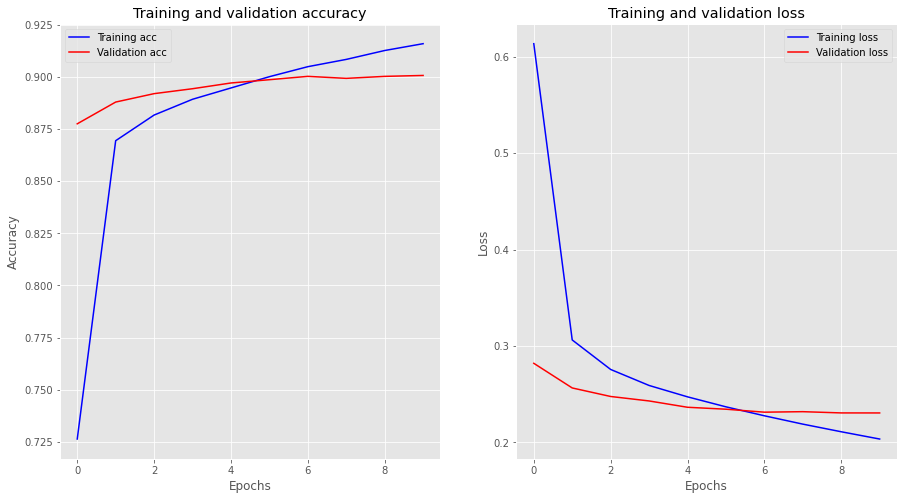

In [23]:
util.plot_accuracy_loss(history, 'CNN')

<b>As per above execution, model of EPOCH 10 is saved as best model, the validation loss is intersected training loss on around 6th EPOCH and seems settled near 0.23. Let's check how it performs for unseen data, if the accuracy of unseen data is aligning with validation accuracy then there is no trace of overfitting.</b>

# **Evaluation**

In [24]:
model = cnn.load_saved_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 121, 100)          15942300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 121, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 118, 128)          51328     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 15,994,015
Trainable params: 15,994,015
Non-trainable params: 0
_________________________________________________________________


In [25]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 11s - loss: 0.2319 - acc: 0.8998
The loss of this model: 0.23
The accuracy of this model: 0.90


#### The testing accuracy is aligning with validation accuracy, shows no overfitting.

# Prediction

In [26]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[54447  8029  2548]
 [ 5265 54141  1463]
 [  486   573 56363]]


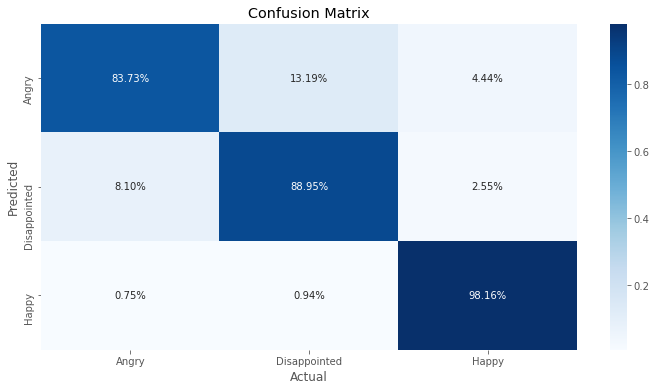

In [27]:
test,pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'CNN')

In [28]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.90      0.84      0.87     65024
           1       0.86      0.89      0.88     60869
           2       0.93      0.98      0.96     57422

    accuracy                           0.90    183315
   macro avg       0.90      0.90      0.90    183315
weighted avg       0.90      0.90      0.90    183315



# <a id= 'cnn2'>**4.2 CNN_v2**

In [29]:
# Below method is commented as now for embedding layer some weight matrix is also provided as input.

# cnn = CNN_Model()
# model = cnn.create_model_v2(embed_dim = 100, num_filters = 128, 
#                           input_len = train_converted.shape[1], feature = 200000, 
#                           drop_out = 0.8, num_words=4)
# model.summary()

In [30]:
cnn = CNN_Model()
model = cnn.create_model_v2(embed_dim = max_len, num_filters = 128, 
                          input_len = train_converted.shape[1], feature = vocab_length, 
                          drop_out = 0.5, num_words=4, embedding_matrix = embedding_matrix )
model.summary()

CNN Model Initialization...
Model Created Successfully...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 121, 100)          15942300  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 121, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 121, 128)          51328     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 121, 128)          65664     
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 121, 128)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
______________________________________________________________

<b> Above neural network is implemented using sequential model in Keras. It contains the series of layers as shown above. <br>
    <li>Embedding layer, embeds the input as per specified weights as embedding matrix. <br>
    <li>Dropout layer, disable the less correlated neurons, the dropout rate is set to 0.5. One more dropout layer is added after convolution to minimize the neurons. <br>
    <li>Convolution layer covolutes as per number of filters and number of words as kernel size. Here two convolution layers are added which convolutes the input. CNN stores the sequential information.<br>
    <li>pooling layer, vectorizes the input.<br>
    <li>dense layer uses activation function as softmax to predict the probability of each target class. Multiple dense layers gradually decreases the dimension. <br>
    <li>The output shape of each layer is as described in model summary.
</b>

In [31]:
history = model.fit(train_converted, target_converted_train, epochs = EPOCH, 
                    batch_size=BATCH_SIZE, validation_split=0.2,
                    callbacks=cnn.callbacks_v2)

Epoch 1/10
287/287 [==============================] - 328s 1s/step - loss: 0.8644 - acc: 0.5686 - val_loss: 0.2780 - val_acc: 0.8789

Epoch 00001: val_loss improved from inf to 0.27799, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN_v2/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN_v2/assets
Epoch 2/10
287/287 [==============================] - 307s 1s/step - loss: 0.3168 - acc: 0.8651 - val_loss: 0.2529 - val_acc: 0.8890

Epoch 00002: val_loss improved from 0.27799 to 0.25290, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN_v2/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN_v2/assets
Epoch 3/10
287/287 [==============================] - 309s 1s/step - loss: 0.2757 - acc: 0.8828 - val_loss: 0.2432 - val_acc: 0.8936

Epoch 00003: val_loss improved from 0.25290 to 0.24316, saving model to /Users/pratiksayanekar/Documents/DL_20200161

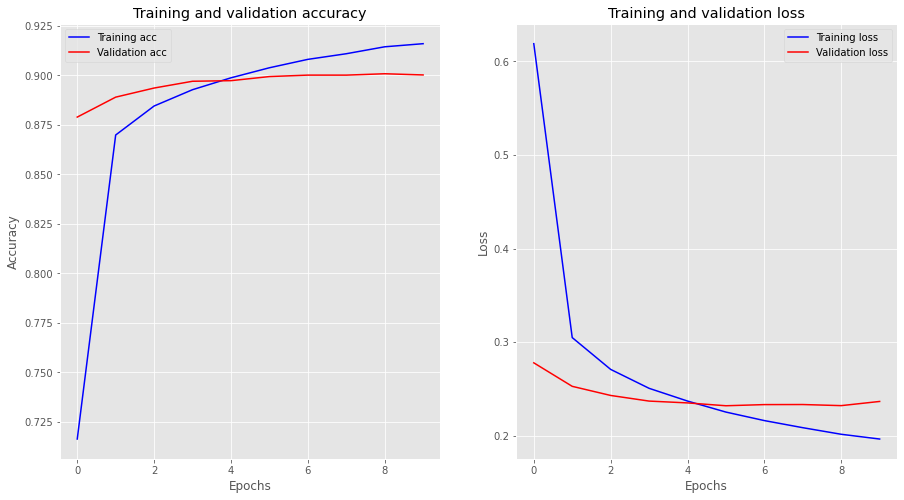

In [32]:
util.plot_accuracy_loss(history, 'CNN_v2')

<b>As per above execution, model of EPOCH 6 is saved as best model, the validation loss is intersects training loss and showing platue. Let's check how it performs for unseen data, if the accuracy of unseen data is aligning with validation accuracy then there is no trace of overfitting.</b>

# **Evaluation**

In [33]:
model = cnn.load_saved_model_v2()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 121, 100)          15942300  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 121, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 121, 128)          51328     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 121, 128)          65664     
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 121, 128)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [34]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 23s - loss: 0.2341 - acc: 0.8989
The loss of this model: 0.23
The accuracy of this model: 0.90


#### The testing accuracy is aligning with validation accuracy, shows no overfitting.

# Prediction

In [35]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[53855  7556  2457]
 [ 5906 54623  1613]
 [  437   564 56304]]


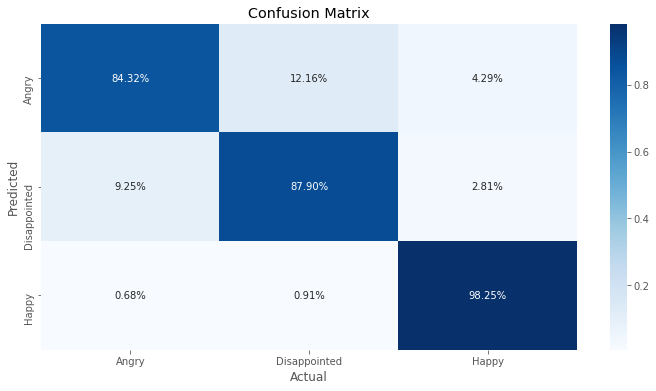

In [36]:
test,pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'CNN_v2')

In [37]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.89      0.84      0.87     63868
           1       0.87      0.88      0.87     62142
           2       0.93      0.98      0.96     57305

    accuracy                           0.90    183315
   macro avg       0.90      0.90      0.90    183315
weighted avg       0.90      0.90      0.90    183315



# <a id= 'lstm'>**4.3 LSTM Model : Long Short Term Memory**

In [38]:
# Below method is commented as now for embedding layer some weight matrix is also provided as input.

# lstm = LSTM_Model()
# model = lstm.create_model(embed_dim = 100, lstm_out = 64, 
#                           input_len = train_converted.shape[1], feature = 200000, 
#                           drop_out = 0.8)
# model.summary()

In [39]:
lstm = LSTM_Model()
model = lstm.create_model(embed_dim = max_len, lstm_out = 64, 
                          input_len = train_converted.shape[1], feature = vocab_length, 
                          drop_out = 0.5, embedding_matrix = embedding_matrix)
model.summary()

LSTM Model Initialization...
Model Created Successfully...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 121, 100)          15942300  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 121, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 15,984,735
Trainable params: 15,984,735
Non-trainable params: 0
_________________________________________________________________


<b> Above neural network is implemented using sequential model in Keras. It contains the series of layers as shown above. <br>
    <li>Embedding layer, embeds the input as per specified weights as embedding matrix. <br>
    <li>Dropout layer, disable the less correlated neurons, the dropout rate is set to 0.5. One more dropout layer is added after convolution to minimize the neurons. <br>
    <li>LSTM is known for keeping the information of recurrent features in one direction.<br>
    <li>dense layer uses activation function as softmax to predict the probability of each target class. <br>
    <li>The output shape of each layer is as described in model summary.
</b>

In [40]:
history = model.fit(train_converted, target_converted_train, epochs = EPOCH, 
                    batch_size= BATCH_SIZE, validation_split=0.2,
                    callbacks=lstm.callbacks)

Epoch 1/10
287/287 [==============================] - 453s 2s/step - loss: 0.8958 - acc: 0.5593 - val_loss: 0.3269 - val_acc: 0.8647

Epoch 00001: val_loss improved from inf to 0.32686, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM/assets
Epoch 2/10
287/287 [==============================] - 454s 2s/step - loss: 0.3838 - acc: 0.8414 - val_loss: 0.2591 - val_acc: 0.8874

Epoch 00002: val_loss improved from 0.32686 to 0.25910, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM/assets
Epoch 3/10
287/287 [==============================] - 453s 2s/step - loss: 0.2968 - acc: 0.8739 - val_loss: 0.2443 - val_acc: 0.8935

Epoch 00003: val_loss improved from 0.25910 to 0.24430, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpo

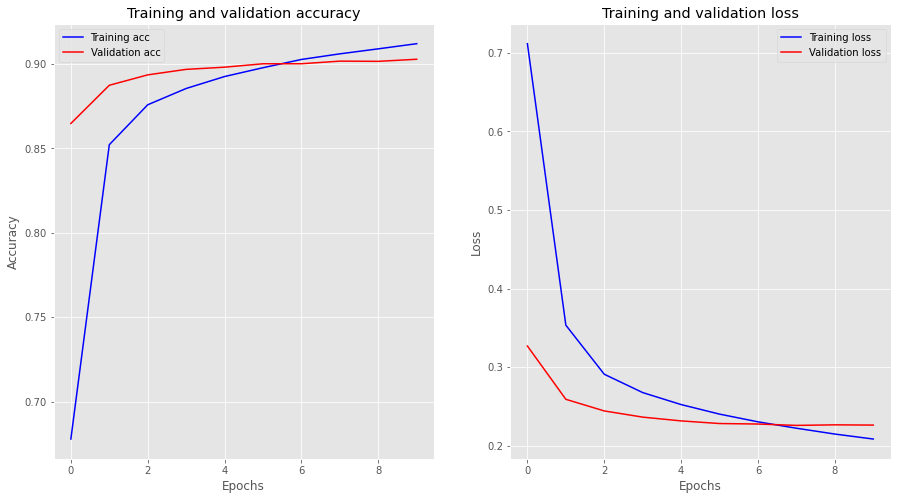

In [41]:
util.plot_accuracy_loss(history, 'LSTM')

<b>As per above execution, model of EPOCH 8 is saved as best model, the validation loss converges to training loss. Let's check how it performs for unseen data, if the accuracy of unseen data is aligning with validation accuracy then there is no trace of overfitting.</b>

# **Evaluation**

In [42]:
model = lstm.load_saved_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 121, 100)          15942300  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 121, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 15,984,735
Trainable params: 15,984,735
Non-trainable params: 0
_________________________________________________________________


In [43]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 29s - loss: 0.2285 - acc: 0.9012
The loss of this model: 0.23
The accuracy of this model: 0.90


#### The testing accuracy is aligning with validation accuracy, shows no overfitting.

# Prediction

In [44]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[54141  7497  2387]
 [ 5650 54615  1548]
 [  407   631 56439]]


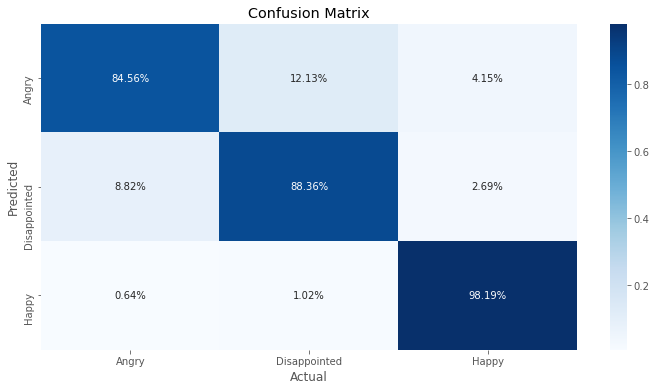

In [45]:
test, pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'LSTM')

In [46]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.90      0.85      0.87     64025
           1       0.87      0.88      0.88     61813
           2       0.93      0.98      0.96     57477

    accuracy                           0.90    183315
   macro avg       0.90      0.90      0.90    183315
weighted avg       0.90      0.90      0.90    183315



# <a id= 'lstm2'>**4.4 LSTM_v2**

In [47]:
# Below method is commented as now for embedding layer, embedded weight matrix is also provided as input.

# lstm = LSTM_Model()
# model = lstm.create_model_v2(embed_dim = 100, lstm_out = 64, 
#                           input_len = train_converted.shape[1], feature = 200000, 
#                           drop_out = 0.8)
# model.summary()

In [48]:
lstm = LSTM_Model()
model = lstm.create_model_v2(embed_dim = max_len, lstm_out = 64, 
                          input_len = train_converted.shape[1], feature = vocab_length, 
                          drop_out = 0.5, embedding_matrix = embedding_matrix )
model.summary()

LSTM Model Initialization...
Model Created Successfully...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 121, 100)          15942300  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 121, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 121, 64)           42240     
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 121, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 121, 64)           33024     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_____________________________________________________________

<b> Above neural network is implemented using sequential model in Keras. It contains the series of layers as shown above. <br>
    <li>Embedding layer, embeds the input as per specified weights as embedding matrix. <br>
    <li>Dropout layer, disable the less correlated neurons, the dropout rate is set to 0.5. One more dropout layer is added after convolution to minimize the neurons. <br>
    <li>LSTM is known for keeping the information of recurrent features in one direction. Here multiple LSTM layers are used. As per provided input to LSTM as lstm_out that is 64 here, the output will vary.<br>
    <li>dense layer uses activation function as softmax to predict the probability of each target class. <br>
    <li>The output shape of each layer is as described in model summary.
</b>

In [49]:
history = model.fit(train_converted, target_converted_train, epochs = EPOCH, 
                    batch_size= BATCH_SIZE, validation_split=0.2,
                    callbacks=lstm.callbacks_v2)

Epoch 1/10
287/287 [==============================] - 1233s 4s/step - loss: 0.9546 - acc: 0.5014 - val_loss: 0.3153 - val_acc: 0.8659

Epoch 00001: val_loss improved from inf to 0.31535, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM_v2/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM_v2/assets
Epoch 2/10
287/287 [==============================] - 1248s 4s/step - loss: 0.3929 - acc: 0.8338 - val_loss: 0.2745 - val_acc: 0.8825

Epoch 00002: val_loss improved from 0.31535 to 0.27452, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM_v2/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM_v2/assets
Epoch 3/10
287/287 [==============================] - 1205s 4s/step - loss: 0.3197 - acc: 0.8622 - val_loss: 0.2613 - val_acc: 0.8880

Epoch 00003: val_loss improved from 0.27452 to 0.26130, saving model to /Users/pratiksayanekar/Documents/DL_2

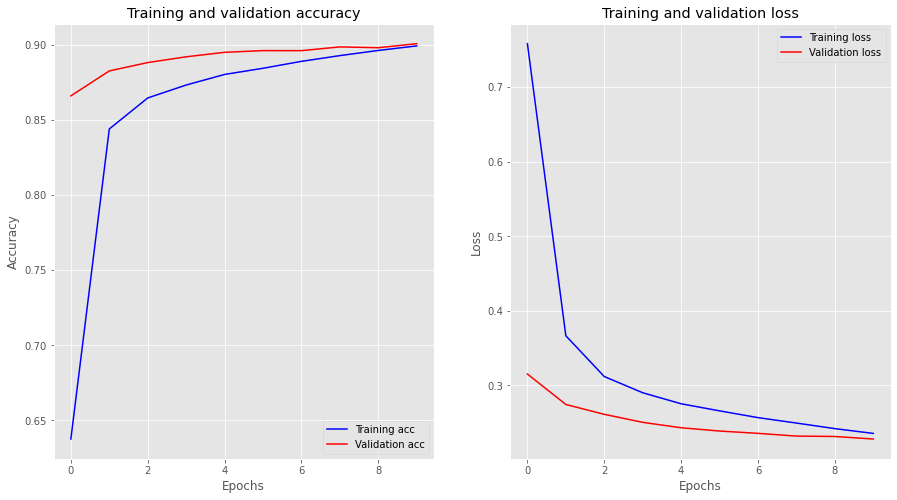

In [50]:
util.plot_accuracy_loss(history, 'LSTM_v2')

<b>As per above execution, model of EPOCH 10 is saved as best model, the validation loss is less than training loss. Let's check how it performs for unseen data, if the accuracy of unseen data is aligning with validation accuracy then there is no trace of overfitting.</b>

# **Evaluation**

In [51]:
model = lstm.load_saved_model_v2()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 121, 100)          15942300  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 121, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 121, 64)           42240     
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 121, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 121, 64)           33024     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [52]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 55s - loss: 0.2317 - acc: 0.8997
The loss of this model: 0.23
The accuracy of this model: 0.90


#### The testing accuracy is aligning with validation accuracy, shows no overfitting.

# Prediction

In [53]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[54112  7697  2418]
 [ 5839 54578  1713]
 [  247   468 56243]]


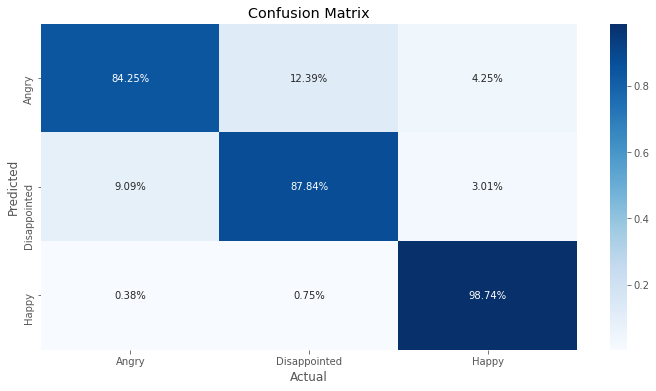

In [54]:
test, pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'LSTM_v2')

In [55]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.90      0.84      0.87     64227
           1       0.87      0.88      0.87     62130
           2       0.93      0.99      0.96     56958

    accuracy                           0.90    183315
   macro avg       0.90      0.90      0.90    183315
weighted avg       0.90      0.90      0.90    183315



# <a id= 'bilstm'> **5. Proposed Model: BiLSTM+CNN**
    
    Here, the advantage of both BiLSTM and CNN is utilised to predict the target class.
    BiLSTM is bidirectional LSTM, will store information of recurrent features. 
    CNN will process features in sequential manner as per privided kernel size.
    

In [56]:
bi_lstm = BiLSTM_Model()
model = bi_lstm.create_model(embed_dim = max_len, lstm_out = 100, input_len = train_converted.shape[1], 
                             feature = vocab_length, drop_out = 0.5, embedding_matrix = embedding_matrix)
model.summary()

BiLSTM Model Initialization...
Model Created Successfully...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 121, 100)          15942300  
_________________________________________________________________
bidirectional (Bidirectional (None, 121, 200)          160800    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 121, 200)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 121, 200)          240800    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 117, 100)          100100    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
___________________________________________________________

<b> Above neural network is implemented using sequential model in Keras. It contains the series of layers as shown above. <br>
    <li>Embedding layer, embeds the input as per specified weights as embedding matrix. <br>
    <li>Dropout layer, disable the less correlated neurons, the dropout rate is set to 0.5. One more dropout layer is added after convolution to minimize the neurons. <br>
    <li>BiLSTM applies the LSTM in both direction that doubles the output.<br>
    <li>CNN layer, as discussed above convolutes the spatial information.<br>
    <li>dense layer uses activation function as softmax to predict the probability of each target class. <br>
    <li>The output shape of each layer is as described in model summary.
</b>

In [57]:
history = model.fit(train_converted, target_converted_train, batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=0.2, callbacks=bi_lstm.callbacks)

Epoch 1/10
287/287 [==============================] - 3556s 12s/step - loss: 0.7722 - acc: 0.6346 - val_loss: 0.2690 - val_acc: 0.8835


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


Epoch 2/10
287/287 [==============================] - 3254s 11s/step - loss: 0.2849 - acc: 0.8790 - val_loss: 0.2402 - val_acc: 0.8951


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


Epoch 3/10
287/287 [==============================] - 3725s 13s/step - loss: 0.2443 - acc: 0.8964 - val_loss: 0.2327 - val_acc: 0.8978


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


Epoch 4/10
287/287 [==============================] - 4053s 14s/step - loss: 0.2222 - acc: 0.9062 - val_loss: 0.2321 - val_acc: 0.9002


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


Epoch 5/10
287/287 [==============================] - 3932s 14s/step - loss: 0.2075 - acc: 0.9118 - val_loss: 0.2307 - val_acc: 0.8986


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


Epoch 6/10
287/287 [==============================] - 3112s 11s/step - loss: 0.1944 - acc: 0.9178 - val_loss: 0.2293 - val_acc: 0.9028


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


Epoch 7/10
287/287 [==============================] - 3050s 11s/step - loss: 0.1847 - acc: 0.9216 - val_loss: 0.2342 - val_acc: 0.9029
Epoch 8/10
287/287 [==============================] - 3039s 11s/step - loss: 0.1778 - acc: 0.9239 - val_loss: 0.2386 - val_acc: 0.9023
Epoch 9/10
287/287 [==============================] - 3031s 11s/step - loss: 0.1713 - acc: 0.9262 - val_loss: 0.2429 - val_acc: 0.9028
Epoch 10/10
287/287 [==============================] - 3028s 11s/step - loss: 0.1658 - acc: 0.9285 - val_loss: 0.2453 - val_acc: 0.9026


<b>As per above execution, model of EPOCH 6 is saved as best model, the validation loss is intersects training loss and showing platue. Let's check how it performs for unseen data, if the accuracy of unseen data is aligning with validation accuracy then there is no trace of overfitting.</b>

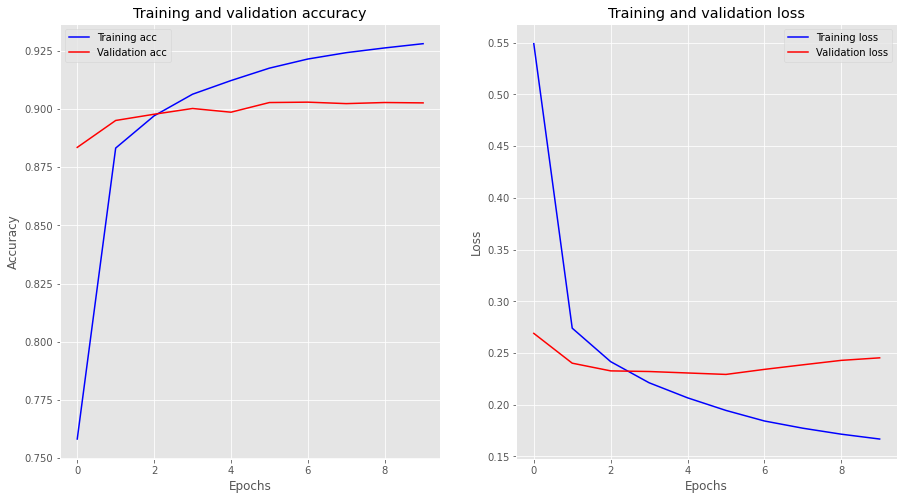

In [60]:
util.plot_accuracy_loss(history, 'BiLSTM')

# **Evaluation**

In [58]:
model = bi_lstm.load_saved_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 121, 100)          15942300  
_________________________________________________________________
bidirectional (Bidirectional (None, 121, 200)          160800    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 121, 200)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 121, 200)          240800    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 117, 100)          100100    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)               

In [59]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 210s - loss: 0.2307 - acc: 0.9019
The loss of this model: 0.23
The accuracy of this model: 0.90


#### The testing accuracy is aligning with validation accuracy, shows no overfitting.

# **Prediction** 

In [61]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[54285  7693  2271]
 [ 5247 54355  1420]
 [  666   695 56683]]


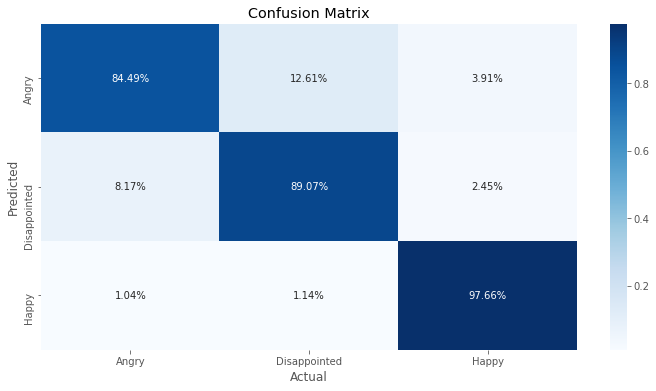

In [62]:
test, pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'BiLSTM')

In [63]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.90      0.84      0.87     64249
           1       0.87      0.89      0.88     61022
           2       0.94      0.98      0.96     58044

    accuracy                           0.90    183315
   macro avg       0.90      0.90      0.90    183315
weighted avg       0.90      0.90      0.90    183315



 # <a id='conclusion'> Conclusion:
 <b>   <li>The testing accuracy of above model is 90%, the accuracy of angry and disappointed is comparatively less as model is perfectly distinguishing tweets with happy emotion.</li>
    <li>The loss of training and validation curve shows no overfitting, provided that the accuracy on unseen data matches the accuracy of validation data.</li>
    <li>Model is performing poor, not actually poor but less efficient while predicting between 'angry' and 'disappointed' tweets. The confusion matrix of all models shows similar results.</li>
    <li>The execution time of epochs can be reduced by adding several layers of dropout but this is avoided as it results in increase of loss.</li>
    <li>The batch size can be increase more than 1024. for example in last saved notebook by increasing batch size to 2048 reduces the number of steps to run one epoch, 587776 samples were trained in 287 steps. On CPU one epoch of BiLSTM takes almost an hour to execute.</li>
    <li>Due to Google collab time limit exhaustion, the latest run is executed on Macbook pro CPU with increased batch size.</li>
</b>    